In [1]:
!hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/

In [2]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/04 18:34:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
banks_df = spark.read.csv("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv", header=True, inferSchema=True)

In [4]:
bankCount = banks_df.rdd.map(lambda row: row[0]).filter(lambda name: "The" in name and "National" in name).count()

In [5]:
#q1
bankCount

106

In [6]:
from pyspark.sql.functions import lower, col
bankCount_2 = banks_df.filter(col("respondent_name").contains("The") & col("respondent_name").contains("National")).count()

In [7]:
#q2
bankCount_2

106

In [8]:
banks_df.write.saveAsTable("banks", mode="overwrite")
banksSQL = spark.sql("SELECT COUNT(*) FROM banks WHERE respondent_name LIKE '%The%' AND respondent_name LIKE '%National%'")

24/04/04 18:34:30 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/04/04 18:34:30 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/04/04 18:34:33 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
24/04/04 18:34:33 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.23.0.3
24/04/04 18:34:35 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
24/04/04 18:34:37 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/04/04 18:34:37 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
24/04/04 18:34:37 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/04/04 18:34:37 W

In [9]:
#q3
banksSQL.collect()[0][0]

106

In [10]:
loans = spark.read.csv("hdfs://nn:9000/hdma-wi-2021.csv", header=True, inferSchema=True)
loans.write.bucketBy(8, "county_code").saveAsTable("loans", mode="overwrite")

24/04/04 18:34:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [11]:
views_to_create = ["ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken",
                   "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type"]

for view_name in views_to_create:
    csv_path = f"hdfs://nn:9000/{view_name}.csv"
    view = spark.read.csv(csv_path, header=True, inferSchema=True)
    view.createOrReplaceTempView(view_name)

In [12]:
tables = spark.sql("SHOW TABLES")
tables_dict = {row['tableName']: row['isTemporary'] for row in tables.collect()}

In [13]:
#q4
tables_dict

{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [14]:
banks = spark.table("banks")
loans = spark.table("loans")
joined_df = spark.sql("""
SELECT *
FROM loans
INNER JOIN banks ON loans.lei = banks.lei_2020
""")

In [15]:
#q5
joined_df.filter(col("respondent_name").like("First National Bank")).count()

6

In [16]:
#q6
spark.sql("""
SELECT *
FROM loans
INNER JOIN banks ON loans.lei = banks.lei_2020
""").explain("formatted")
#6.1: The banks table.
#6.2: No HashAggregates. The primary operation is the BroadcastHashJoin.

== Physical Plan ==
AdaptiveSparkPlan (7)
+- BroadcastHashJoin Inner BuildRight (6)
   :- Filter (2)
   :  +- Scan parquet spark_catalog.default.loans (1)
   +- BroadcastExchange (5)
      +- Filter (4)
         +- Scan parquet spark_catalog.default.banks (3)


(1) Scan parquet spark_catalog.default.loans
Output [99]: [activity_year#991, lei#992, derived_msa-md#993, state_code#994, county_code#995, census_tract#996, conforming_loan_limit#997, derived_loan_product_type#998, derived_dwelling_category#999, derived_ethnicity#1000, derived_race#1001, derived_sex#1002, action_taken#1003, purchaser_type#1004, preapproval#1005, loan_type#1006, loan_purpose#1007, lien_status#1008, reverse_mortgage#1009, open-end_line_of_credit#1010, business_or_commercial_purpose#1011, loan_amount#1012, loan_to_value_ratio#1013, interest_rate#1014, rate_spread#1015, hoepa_status#1016, total_loan_costs#1017, total_points_and_fees#1018, origination_charges#1019, discount_points#1020, lender_credits#1021, loan_ter

In [17]:
from pyspark.sql.functions import desc

wells_fargo_lei = spark.sql("""
    SELECT lei_2020
    FROM banks
    WHERE respondent_name LIKE 'Wells Fargo%'
""").head()["lei_2020"]

query = """
    SELECT COUNTIES.NAME AS county_name, 
           AVG(loans.loan_amount) AS avg_loan_amount,
           COUNT(loans.loan_amount) AS num_applications
    FROM loans
    JOIN COUNTIES ON loans.county_code = COUNTIES.STATE * 1000 + COUNTIES.COUNTY
    WHERE loans.lei = '{}'
    GROUP BY COUNTIES.NAME
    ORDER BY avg_loan_amount DESC
    LIMIT 10
""".format(wells_fargo_lei)

result = spark.sql(query).collect()
highest_app_count = {row["county_name"]: row["num_applications"] for row in result}

In [18]:
#q7
highest_app_count

{'Sawyer': 38,
 'Door': 174,
 'Forest': 7,
 'Ozaukee': 389,
 'Bayfield': 33,
 'Waukesha': 1832,
 'Vilas': 68,
 'Dane': 729,
 'Oneida': 70,
 'Florence': 8}

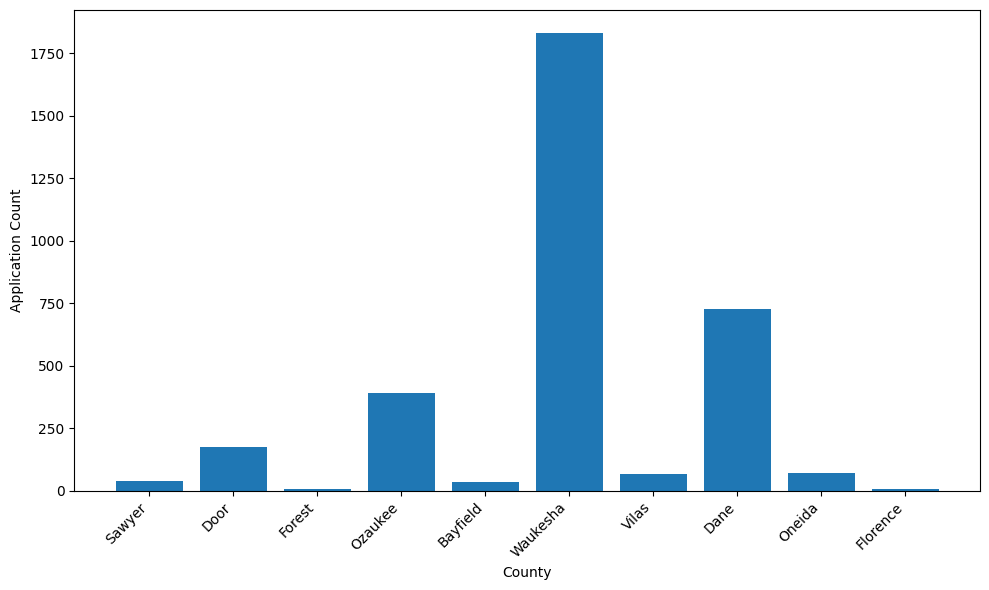

In [19]:
import matplotlib.pyplot as plt

result_dict = dict(highest_app_count)
counties = list(result_dict.keys())
highest_count = list(result_dict.values())

plt.figure(figsize=(10, 6))
plt.bar(counties, highest_count)
plt.xlabel('County')
plt.ylabel('Application Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [20]:
# Simple GROUP BY queries:
spark.sql("""
SELECT county_code, AVG(loan_amount) AS avg_loan_amount
FROM loans
GROUP BY county_code
""").explain("formatted")

== Physical Plan ==
AdaptiveSparkPlan (4)
+- HashAggregate (3)
   +- HashAggregate (2)
      +- Scan parquet spark_catalog.default.loans (1)


(1) Scan parquet spark_catalog.default.loans
Output [2]: [county_code#995, loan_amount#1012]
Batched: true
Bucketed: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/loans]
ReadSchema: struct<county_code:string,loan_amount:double>
SelectedBucketsCount: 8 out of 8

(2) HashAggregate
Input [2]: [county_code#995, loan_amount#1012]
Keys [1]: [county_code#995]
Functions [1]: [partial_avg(loan_amount#1012)]
Aggregate Attributes [2]: [sum#1538, count#1539L]
Results [3]: [county_code#995, sum#1540, count#1541L]

(3) HashAggregate
Input [3]: [county_code#995, sum#1540, count#1541L]
Keys [1]: [county_code#995]
Functions [1]: [avg(loan_amount#1012)]
Aggregate Attributes [1]: [avg(loan_amount#1012)#1535]
Results [2]: [county_code#995, avg(loan_amount#1012)#1535 AS avg_loan_amount#1534]

(4) AdaptiveSparkPlan
Output [2]: [county_code#995,

In [21]:
spark.sql("""
SELECT lei, AVG(loan_amount) AS avg_loan_amount
FROM loans
GROUP BY lei
""").explain("formatted")

== Physical Plan ==
AdaptiveSparkPlan (5)
+- HashAggregate (4)
   +- Exchange (3)
      +- HashAggregate (2)
         +- Scan parquet spark_catalog.default.loans (1)


(1) Scan parquet spark_catalog.default.loans
Output [2]: [lei#992, loan_amount#1012]
Batched: true
Bucketed: false (bucket column(s) not read)
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/loans]
ReadSchema: struct<lei:string,loan_amount:double>

(2) HashAggregate
Input [2]: [lei#992, loan_amount#1012]
Keys [1]: [lei#992]
Functions [1]: [partial_avg(loan_amount#1012)]
Aggregate Attributes [2]: [sum#1546, count#1547L]
Results [3]: [lei#992, sum#1548, count#1549L]

(3) Exchange
Input [3]: [lei#992, sum#1548, count#1549L]
Arguments: hashpartitioning(lei#992, 200), ENSURE_REQUIREMENTS, [plan_id=812]

(4) HashAggregate
Input [3]: [lei#992, sum#1548, count#1549L]
Keys [1]: [lei#992]
Functions [1]: [avg(loan_amount#1012)]
Aggregate Attributes [1]: [avg(loan_amount#1012)#1543]
Results [2]: [lei#992, avg(loan_am

In [22]:
#q8
# Mean and Partial Mean don't require this is because the county_code is part of the same table (loans) that is stored locally in Hive.
# However, when grouping by the lei column, network I/O might be required because lei column refers to another table (banks) that could be distributed across the cluster.
# The partial_mean operation might be performed on different nodes, and then the mean operation needs to combine them, requiring network I/O

In [23]:
from pyspark.sql.functions import when
df = loans.select(col("loan_amount").cast("double"),
                  col("income").cast("double"),
                  col("interest_rate").cast("double"),
                  when(col("action_taken") == 1, 1).otherwise(0).alias("approval"))

In [24]:
df = df.na.fill(0.0)
train, test = df.randomSplit([0.8, 0.2], seed=41)
train.cache()
approved_loans_count = train.filter(df.approval == 1).count()

In [25]:
#q9
approved_loans_count

242868

In [26]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [27]:
feature_cols = ["loan_amount", "income", "interest_rate"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

train_assembled = assembler.transform(train)
test_assembled = assembler.transform(test)

dt = DecisionTreeClassifier(labelCol="approval", featuresCol="features", maxDepth=5)

dt_model = dt.fit(train_assembled)

predictions = dt_model.transform(test_assembled)

evaluator = MulticlassClassificationEvaluator(labelCol="approval", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

In [28]:
#q10
accuracy

0.8931199145137413